In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hnswlib
from sklearn.neighbors import NearestNeighbors
from heapq import heappush, heappop

In [6]:

# Path to your GloVe file (update this based on your downloaded version)
glove_path = "/Users/tejasmacipad/Desktop/Projects/DataScience/datascience-HNSW/glove/glove.6B.100d.txt"

# Load GloVe vectors
word_to_vec = {}
words = []
vectors = []

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # First token is the word
        vector = np.array(values[1:], dtype=np.float32)  # Rest are vector values
        word_to_vec[word] = vector
        words.append(word)
        vectors.append(vector)

# Convert to numpy array
vectors = np.array(vectors, dtype=np.float32)
print(f"Loaded {len(words)} word vectors of dimension {vectors.shape[1]}")

Loaded 400000 word vectors of dimension 100


# Query and output generation

#### Model with l2

In [7]:
dim = vectors.shape[1]  # Embedding dimension
num_elements = len(words)  # Number of words

# Initialize HNSW index
hnsw_index = hnswlib.Index(space="l2", dim=dim)  # "l2" is Euclidean distance

# Set up the index
hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=16)

# Add word vectors to the index
hnsw_index.add_items(vectors)

print("HNSW index built successfully!")

HNSW index built successfully!


In [8]:
def find_similar_words(query_word, k=6):
    if query_word not in word_to_vec:
        return f"'{query_word}' not found in vocabulary!"

    query_vector = word_to_vec[query_word].reshape(1, -1)
    labels, distances = hnsw_index.knn_query(query_vector, k=k)

    print(f"\nTop {k} words similar to '{query_word}':")
    for i, index in enumerate(labels[0]):
        print(f"{i+1}. {words[index]} (Distance: {distances[0][i]:.4f})")


In [9]:
# Example Query
find_similar_words("king", k=5)


Top 5 words similar to 'king':
1. king (Distance: 0.0000)
2. prince (Distance: 16.7458)
3. queen (Distance: 18.3291)
4. monarch (Distance: 20.0182)
5. brother (Distance: 20.5814)


#### Model with cosine

In [10]:
dim = vectors.shape[1]  # Embedding dimension
num_elements = len(words)  # Number of words

# Initialize HNSW index
hnsw_index_cosine = hnswlib.Index(space="cosine", dim=dim)  # "l2" is Euclidean distance

# Set up the index
hnsw_index_cosine.init_index(max_elements=num_elements, ef_construction=200, M=16)

# Add word vectors to the index
hnsw_index_cosine.add_items(vectors)

print("HNSW index built successfully!")

HNSW index built successfully!


In [11]:
def find_similar_words_cosine(query_word, k=6):
    if query_word not in word_to_vec:
        return f"'{query_word}' not found in vocabulary!"

    query_vector = word_to_vec[query_word].reshape(1, -1)
    labels, distances = hnsw_index_cosine.knn_query(query_vector, k=k)

    print(f"\nTop {k} words similar to '{query_word}':")
    for i, index in enumerate(labels[0]):
        print(f"{i+1}. {words[index]} (Distance: {distances[0][i]:.4f})")

In [12]:
for a in range(1):
    find_similar_words_cosine("king", k=10)


Top 10 words similar to 'king':
1. king (Distance: -0.0000)
2. prince (Distance: 0.2318)
3. queen (Distance: 0.2492)
4. son (Distance: 0.2979)
5. brother (Distance: 0.3014)
6. monarch (Distance: 0.3022)
7. throne (Distance: 0.3080)
8. kingdom (Distance: 0.3189)
9. father (Distance: 0.3198)
10. emperor (Distance: 0.3287)


Using k means to get query and correponding output

In [13]:
# Step 1: Generate 10^5 random query indices
num_queries = 10**5
query_indices = np.random.randint(0, len(words), size=num_queries)

# Step 2: Get the corresponding query vectors
query_vectors = vectors[query_indices]

# Step 3: Use NearestNeighbors to find 100 nearest neighbors
k = 100
nn = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='l2')
nn.fit(vectors)

# Step 4: For each query, get the indices of the 100 nearest neighbors
distances, neighbor_indices = nn.kneighbors(query_vectors)

# Step 5: Store results in a dictionary {query_word: [neighbor_words]}
query_to_neighbors = {}

from tqdm import tqdm

# Step 5: Store results in a dictionary {query_word: [neighbor_words]}
query_to_neighbors = {}
for i in tqdm(range(len(query_indices)), desc="Finding nearest neighbors"):
    query_idx = query_indices[i]
    query_word = words[query_idx]
    neighbor_words = [words[idx] for idx in neighbor_indices[i]]
    query_to_neighbors[query_word] = neighbor_words

print(f"Stored nearest neighbors for {len(query_to_neighbors)} queries.")


Finding nearest neighbors: 100%|██████████| 100000/100000 [00:02<00:00, 48642.53it/s]

Stored nearest neighbors for 88440 queries.


In [ ]:
import json

with open("query_neighbors.json", "w") as f:
    json.dump(query_to_neighbors, f)



There are less number of queries stored in dictionary because some of them we repeated, because of which dictionary removed the repititions;

Based on this we can map the frequency of the outputs obtained from these queries

In [15]:
import json

# Load the saved query-to-neighbors mapping
with open("query_neighbors.json", "r") as f:
    query_to_neighbors = json.load(f)

print(f"Loaded {len(query_to_neighbors)} queries from file.")

# Step 6: Create a dictionary mapping each unique query_word to its vector
query_word_vectors = {word: word_to_vec[word] for word in query_to_neighbors}

print(f"Stored vectors for {len(query_word_vectors)} unique query words.")



Loaded 88299 queries from file.
Stored vectors for 88299 unique query words.


Frequency count

In [16]:
query_to_neighbors_vectors = {}

for i in tqdm(range(len(query_indices)), desc="Finding nearest neighbors"):
    query_idx = query_indices[i]
    neighbor_indices_list = neighbor_indices[i]
    query_to_neighbors_vectors[query_idx] = neighbor_indices_list  # All indices, not vectors


Finding nearest neighbors: 100%|██████████| 100000/100000 [00:00<00:00, 747039.22it/s]


In [17]:
from collections import Counter
import pandas as pd

# Flatten all neighbor indices into a single list
all_neighbors = [idx for neighbors in query_to_neighbors_vectors.values() for idx in neighbors]

# Count frequency of each neighbor index
freq_counter = Counter(all_neighbors)

# Create DataFrame and sort
freq_df = pd.DataFrame(freq_counter.items(), columns=["Index", "Frequency"]).sort_values("Frequency", ascending=False)



In [18]:
print(len(all_neighbors))

8844000


As we have unique 88508 and each one of them has 100 outputs, we can use the frequency count.

In [19]:
print(freq_df.head())  # Preview
print(freq_df.tail())  # Preview

       Index  Frequency
1309  154957       9986
2365  289249       9833
1332  364978       9056
2366  224673       8715
2400  262208       7330
         Index  Frequency
312838  180067          1
312841   92329          1
312842  243938          1
312848   44215          1
362029   31899          1


### Frequency count of the outputs obtained from the queries

In [20]:
#printing the average
average = freq_df["Frequency"].mean()
print(f"Average frequency of neighbors: {average}")

Average frequency of neighbors: 24.42891473082341


In [21]:
print(len(freq_df))  # Total unique neighbors

362030


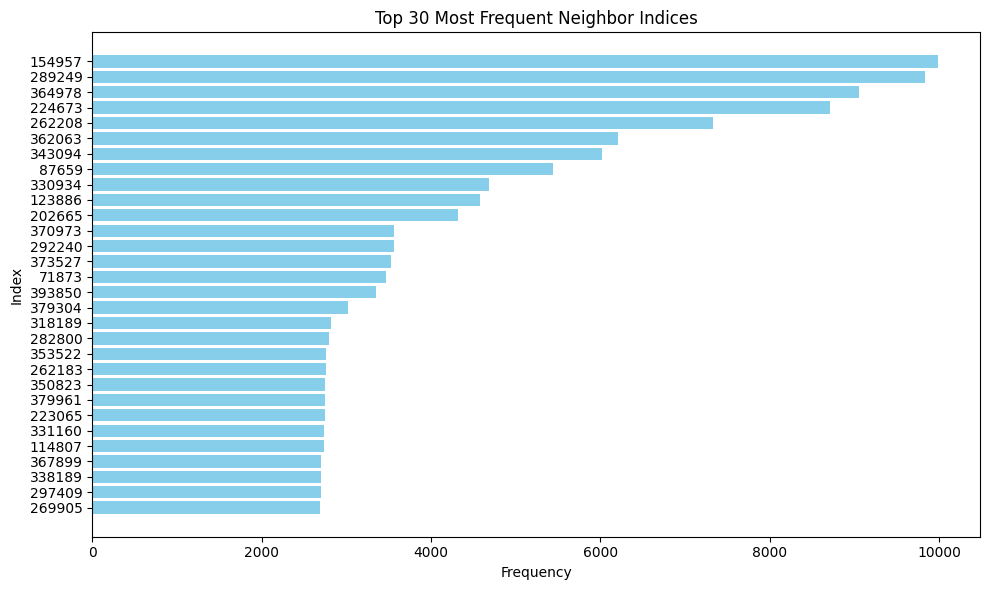

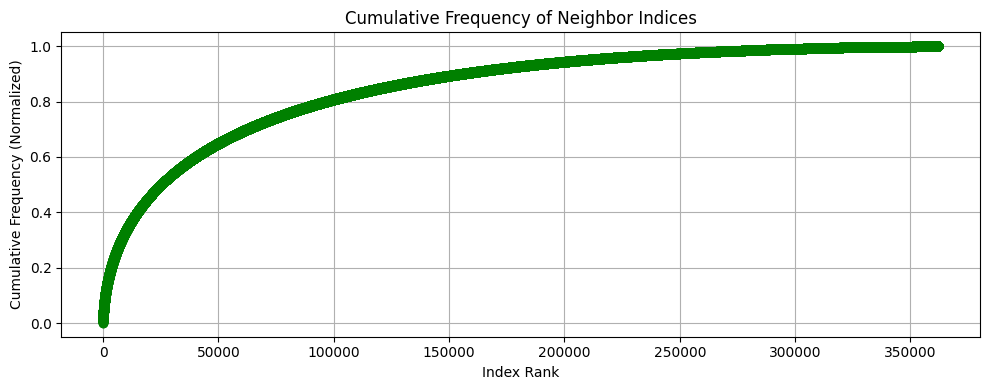

In [22]:
import matplotlib.pyplot as plt
import squarify  # pip install squarify if not already installed
import numpy as np

# Select top N most frequent indices
top_n = 30
freq_top = freq_df.head(top_n)

# 1. Horizontal Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(freq_top["Index"].astype(str), freq_top["Frequency"], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Index")
plt.title(f"Top {top_n} Most Frequent Neighbor Indices")
plt.gca().invert_yaxis()  # Highest freq on top
plt.tight_layout()
plt.show()

# 3. Cumulative Frequency Line Plot
freq_df_sorted = freq_df.sort_values("Frequency", ascending=False)
cum_freq = np.cumsum(freq_df_sorted["Frequency"])
cum_freq = cum_freq / cum_freq.max()  # Normalize to 0–1

plt.figure(figsize=(10, 4))
plt.plot(range(len(cum_freq)), cum_freq, marker='o', linestyle='-', color='green')
plt.title("Cumulative Frequency of Neighbor Indices")
plt.xlabel("Index Rank")
plt.ylabel("Cumulative Frequency (Normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Base Code

In [23]:
class HNSW:
    def __init__(self, dim, max_elements, M=16, ef_construction=200):
        self.dim = dim
        self.max_elements = max_elements
        self.M = M  # Maximum number of connections per layer
        self.ef_construction = ef_construction  # Candidate list size during construction
        self.layers = []  # Multi-layer graph

    def _get_layer(self):
        """Determine the layer for a new node based on exponential decay."""
        return int(-np.log(np.random.random()) * self.M)

    def _distance(self, vec1, vec2):
        """Compute Euclidean distance between two vectors."""
        return np.linalg.norm(vec1 - vec2)

    def _search_layer(self, graph, query, ef):
        """Search for nearest neighbors in a specific layer."""
        visited = set()
        candidates = []
        heappush(candidates, (0, query))  # Start with the query itself
        neighbors = []

        while candidates:
            dist, current = heappop(candidates)
            if current in visited:
                continue
            visited.add(current)
            neighbors.append((dist, current))
            if len(neighbors) > ef:
                neighbors.pop()
            for neighbor in graph[current]:
                if neighbor not in visited:
                    heappush(candidates, (self._distance(query, neighbor), neighbor))

        return neighbors

    # def insert(self, vector):
    #     """Insert a vector into the HNSW index."""
    #     layer = self._get_layer()
    #     while len(self.layers) <= layer:
    #         self.layers.append([])

    #     for l in range(layer + 1):
    #         graph = self.layers[l]
    #         if not graph:  # First vector in this layer
    #             graph.append([vector])
    #             continue

    #         neighbors = self._search_layer(graph, vector, self.ef_construction)
    #         connections = [n[1] for n in neighbors[:self.M]]
    #         graph.append([vector] + connections)

    def insert(self, vector):
        """Insert a vector into the HNSW index with bidirectional edges."""
        layer = self._get_layer()
        while len(self.layers) <= layer:
            self.layers.append([])

        for l in range(layer + 1):
            graph = self.layers[l]

            # Map each node to its list of connections for easier back-links
            if not graph:
                graph.append([vector])  # First node, no neighbors
                continue

            neighbors = self._search_layer(graph, vector, self.ef_construction)
            connections = [n[1] for n in neighbors[:self.M]]

            # Add the new node and its connections
            graph.append([vector] + connections)

            # Add back-links to connected nodes (bidirectional edges)
            for idx, node in enumerate(graph):
                if node[0] in connections:
                    if vector not in node[1:]:
                        graph[idx].append(vector)


    def search(self, query, k=10):
        """Search for the top-k nearest neighbors."""
        best_neighbors = []
        for layer in reversed(range(len(self.layers))):  # Start from top layer
            graph = self.layers[layer]
            neighbors = self._search_layer(graph, query, k)
            best_neighbors.extend(neighbors)

        best_neighbors.sort(key=lambda x: x[0])  # Sort by distance
        return [n[1] for n in best_neighbors[:k]]



The constructor initializes the HNSW object with the following parameters:

**dim:** The dimensionality of the vectors being indexed.

**max_elements:** The maximum number of elements that can be stored in the index.

**M:** The maximum number of connections (edges) a node can have in each layer. This parameter controls the graph's connectivity.

**ef_construction:** The size of the candidate list during graph construction. Larger values improve accuracy but increase computational cost.

**layers:** A list that stores multiple layers of graphs. Each layer is a graph represented as an adjacency list.